In [3]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from itertools import product

#NOTA IMPORTANTE.
#La parte del EDA de este proyecto es exactamente la misma que la del de "decision tree"
#El objetivo del EDA es familiarizarnos con los datos. Al ser los mismos datos que antes, ya estamos familiarizados

df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv").iloc[:,1:]
pd.set_option("display.max_columns", None)
df.head()

,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
2,183,64,0,0,23.3,0.672,32,1
3,89,66,23,94,28.1,0.167,21,0
4,137,40,35,168,43.1,2.288,33,1


In [2]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Glucose                   768 non-null    int64  
 1   BloodPressure             768 non-null    int64  
 2   SkinThickness             768 non-null    int64  
 3   Insulin                   768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


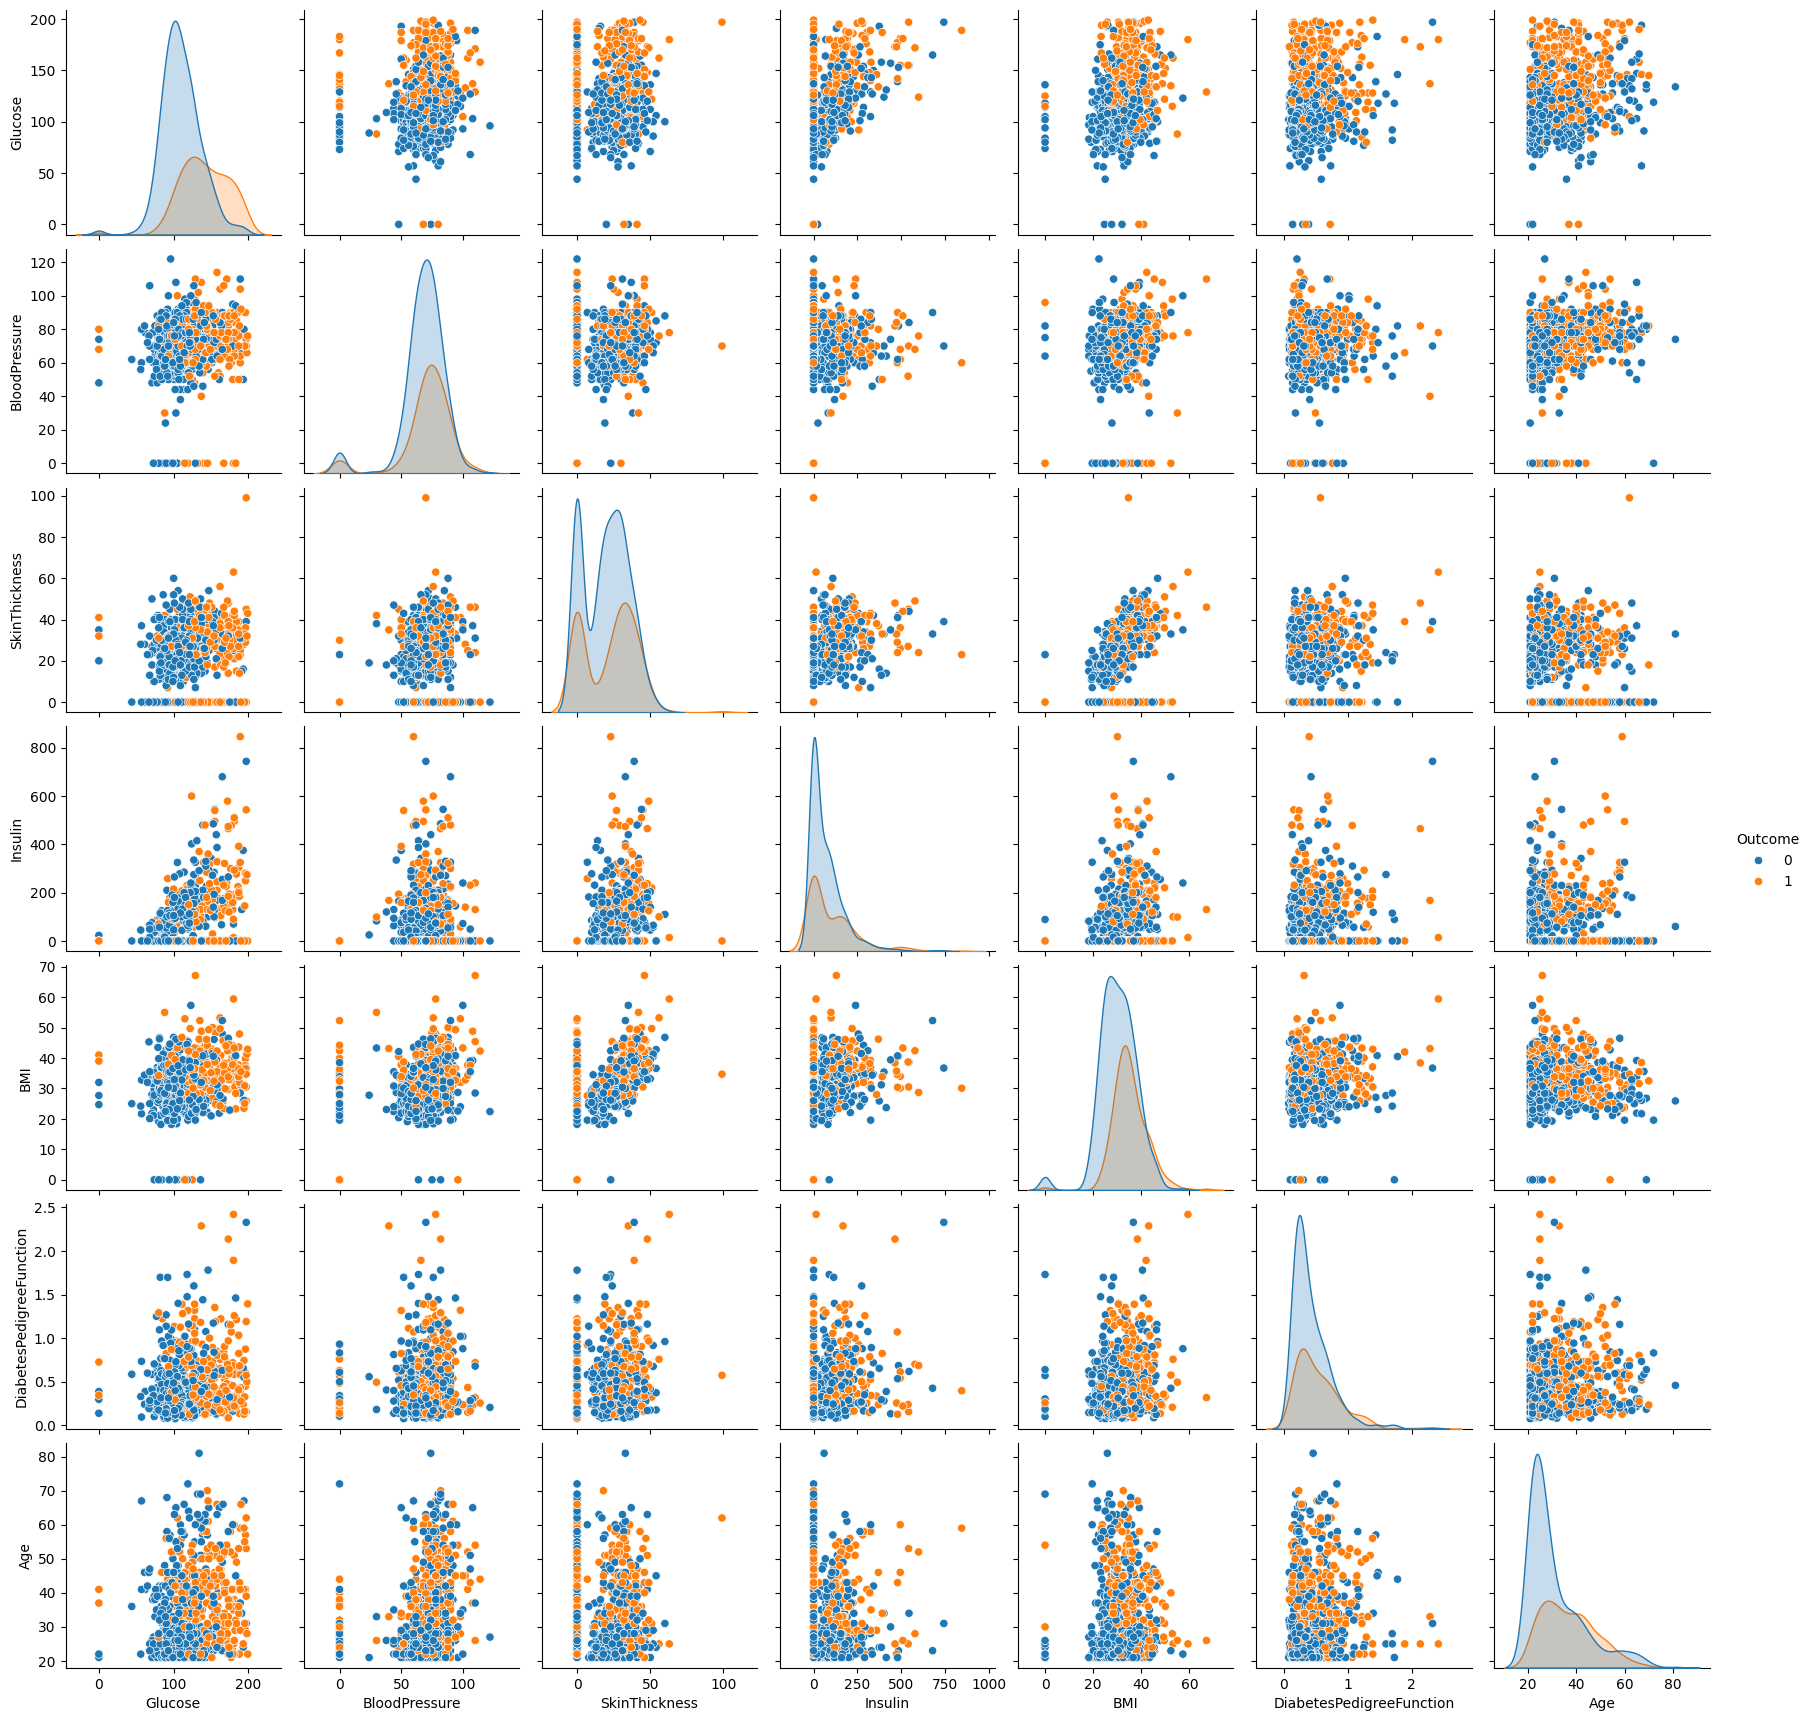

In [4]:
#Para este EDA voy a empezar sacando todos los pairplot. No hay muchas variables,
#con lo cual sale rápido y se puede leer bien
sns.pairplot(df, hue='Outcome')
plt.show()

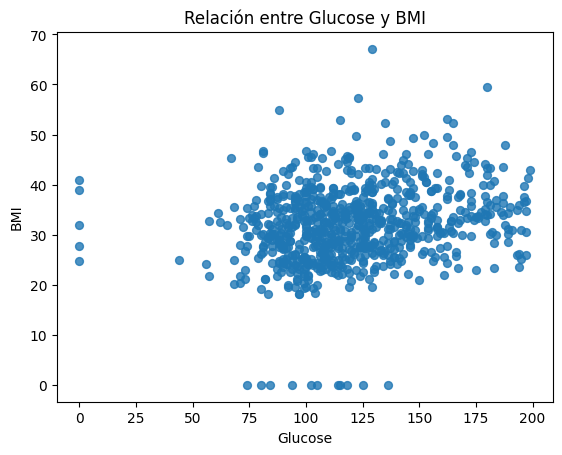

In [5]:
# Voy a hacer un pequeño aumento en el de glucosa vs indice de masa corporal. En primer lugar vemos
#que los datos tienden a agruparse alrededor de 30 en BMI y 115 en glucosa. De por sí no son números
#que me sorprendan mucho, pues un indice de masa corporal de 30 es ser obeso y tener entre 100-125 es
#prediabetes por lo que acabo de leer. Evidentemente ambas pueden estar causadas por no comer de manera
#saludable (además de muchos otros factores), pero es razonable incluso intuitivamente que alguien con
#sobrepeso pueda tener también diabetes. La comorbilidad es bastente común en personas obesas, y este no
#es el primer EDA que lo evidencia.
#Al margen de esto, lo que me precupan son los ceros, pues nadie tiene un IMC de cero (nadie con una altura
# finita, como es el caso de todos los humanos)
#Por lo que he visto en este informe https://www.psychiatriapolska.pl/pdf-126233-81794?filename=81794.pdf
#La persona con el menor IMC que hayan observado era de 6,7! Lo cual ya es una locura
#Supongamos que la persona medía 1,60m ---> Tendría un peso de 17,15kg
#Supongamos que la persona medía mucho (porque siempre habrá alguien que dirá que el IMC no refleja bien
#la realidad de las personas más altas). Si medía 2,10 entonces pesaba 29,55kg

#En cualquier caso, es claro que podemos descartar que los ceros sean valores reales, y por tanto habrá que
#eliminarlos, ya que nos restan valor predictivo

#En un primer momento consideré la posibilidad de sustituir los ceros por valores promedio, pero da la impresión
#de no haber demasiados, y por tanto puede ser más interesante deshacerse de unos pocos para mantener la pureza del conjunto
#Además, convedría hacer un análisis de la cantidad de outliers para ver si se puede proceder igual con esos valores atípicos

df.plot(kind='scatter', x='Glucose', y='BMI', s=32, alpha=0.8)
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.title('Relación entre Glucose y BMI')
plt.show()

In [6]:
#Estas son las columnas en las que un 0 no tiene sentido. En otras como embarazos, incluso edad
#los he dejado intactos a pesar de contener un 0, ya que es un valor posible.
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

#Aquí saco las columas según la cantidad de ceros que contengan
print("Cantidad de ceros por columna:")
print(df[columns_with_zeros].eq(0).sum())

#Y las elimino
df_limpio = df[(df['Glucose'] != 0) &
                    (df['BloodPressure'] != 0) &
                    (df['SkinThickness'] != 0) &
                    (df['Insulin'] != 0) &
                    (df['BMI'] != 0)]

#Voy a sacar los datos de antes y después de la limpieza
print(f"Tamaño original: {df.shape}")
print(f"Tamaño después de eliminar ceros: {df_limpio.shape}")

Cantidad de ceros por columna:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64
Tamaño original: (768, 8)
Tamaño después de eliminar ceros: (392, 8)


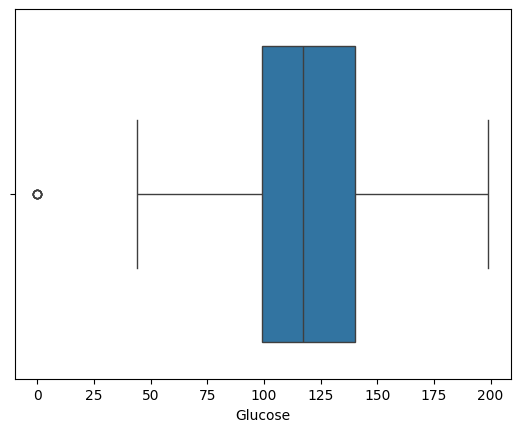

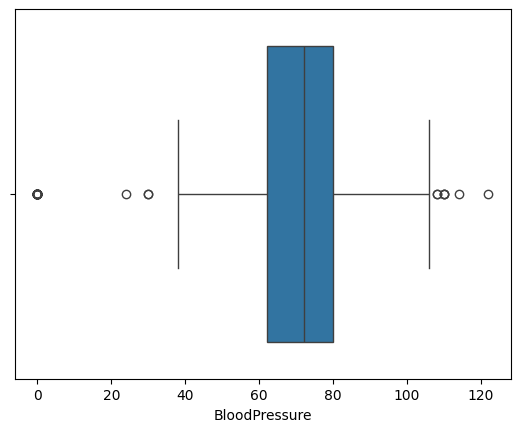

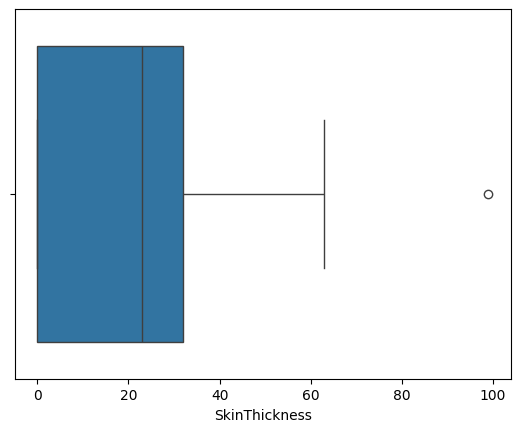

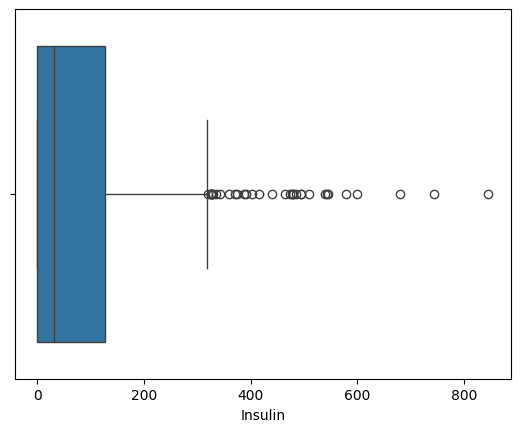

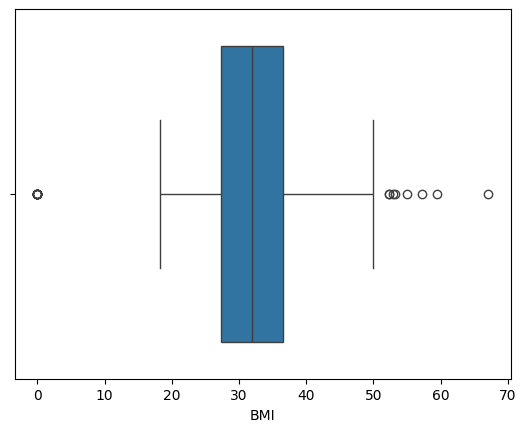

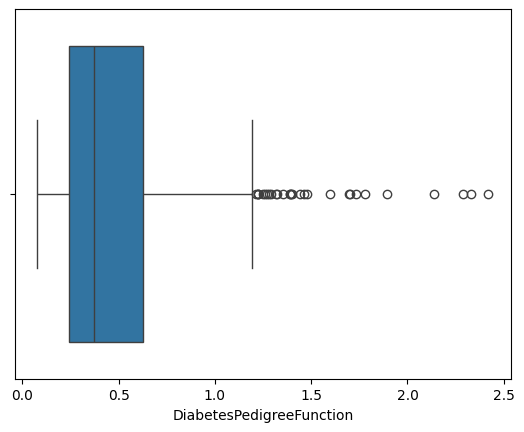

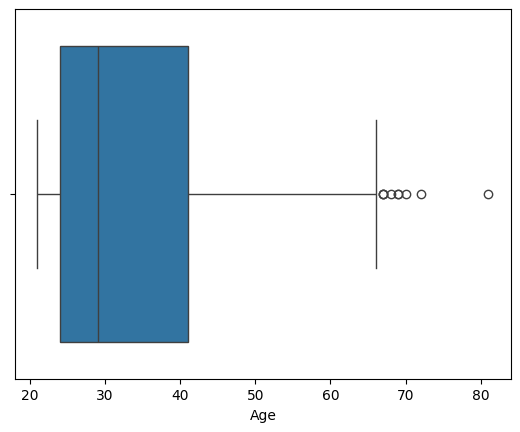

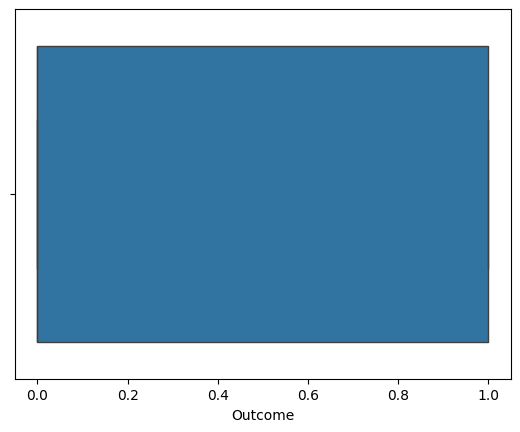

In [7]:
#Voy a familiarizarme también con la distribución de los datos de cada columna
#con un boxplot. Puede ser relevante para concer la edad de la muestra y o cuan extremos
#pueden llegar a ser los casos de la insulina, como se puede apreciar abajo
for col in df.columns:
    if df[col].dtype != 'object':
        sns.boxplot(x=df[col])
        plt.show()

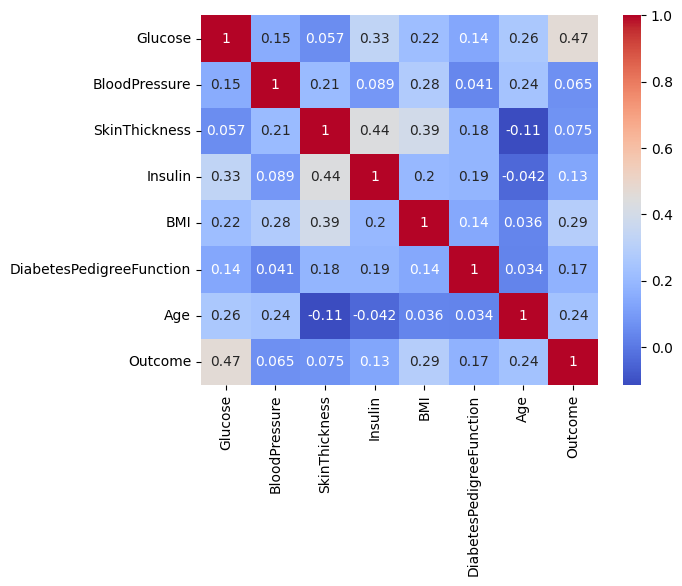

In [8]:
#Ahora un mapa de correlación para ver qué elementos tienen mayor influencia entre sí
#La diagonal compuesta por todo 1s es evidente que no significa nada, aunque me gusta dejarla
#porque si no encontramos todo 1s ya sabemos que algo va mal. Por supuesto todas las variables
#tienen correlación 1 consigo mismas.

#Vemos también que el resto de correlaciones son significativamente más débiles.
#Por supuesto este no es el mapa más eficiente posible, ya que la mitad que marca la diagonal de los
# 1s marca la simetría del mapa. Pero nos sirve para hacernos una buena idea de por dónde van a ir
#las correlaciones
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

Accuracy: 0.6623376623376623
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       100
           1       0.52      0.43      0.47        54

    accuracy                           0.66       154
   macro avg       0.62      0.61      0.61       154
weighted avg       0.65      0.66      0.65       154



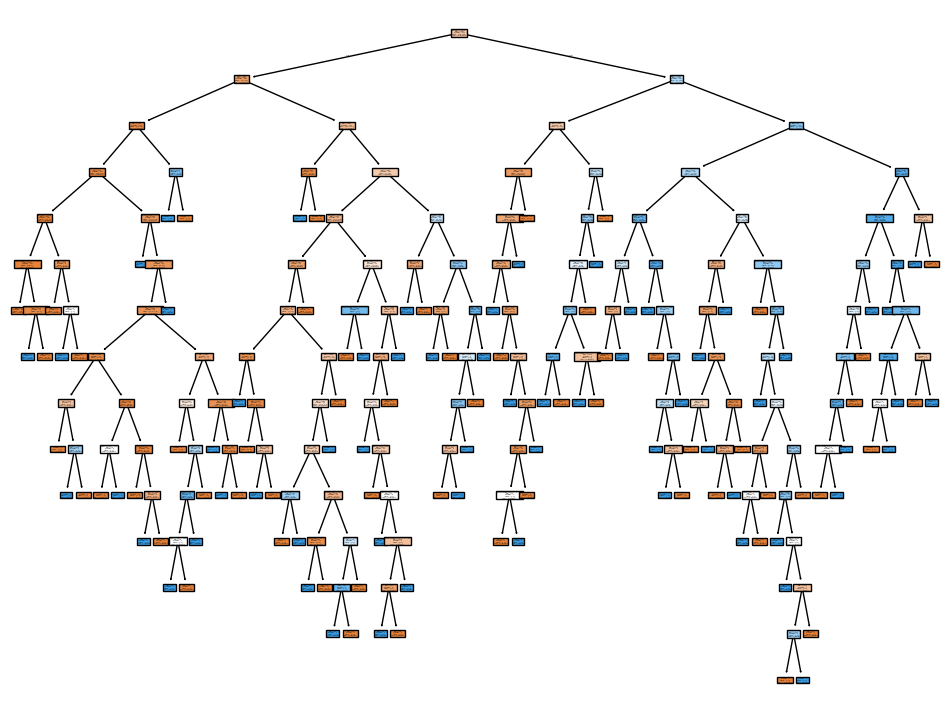

In [9]:
#Llegó el momento de entrenar el modelo! Por supuesto, la variable a separar es outcome
X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19, stratify=y)

#Voy a mantener random state en el mismo número, aunque sean parámetros independientes, para simplificar
#en caso de que alguien desee replicarlo.
clf = DecisionTreeClassifier(random_state=19)

#Con esta funciones entreno al modelo y guardo sus predicciones
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

#Además puedo imprimirme directamtente los reportes con:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Después de probar varias salidas de tamaño, creo que la que mejor se ve es (12,9)
plt.figure(figsize=(12, 9))
plot_tree(clf, feature_names=X.columns, class_names=['No Diabetes', 'Diabetes'], filled=True)
plt.show()

#Observo que es un árbol muy complejo en el que se podrían diferenciar cuatro subgrupos
# principales, dos de ellos siendo claramente dominantes.
#Más allá de esto, obtenemos una accuracy de 66,23% (casi 2/3)

In [10]:
#Pero 2/3 de accuracy no es suficiente para mí! (Ni para este proyecto)
#Ahora hay que buscar en el infinito campo de los hiperparámetros para ver si encontramos
#alguno más óptimo

# He estado probando varios espacios y este es el que mejor ha ido. El top 3 han sido 69%, 72% y 72,07%
#Como he visto que mi equipo podía con ello, he estado buscando qué más hiperparámetros relevantes incluir
#y he añadido los últimos para limitar el número de características consideradas y par incremntar el control
#sobre la reducción mínima de impureza
param_grid = {
    'max_depth': [3, 5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_impurity_decrease': [0.0, 0.01, 0.1]
}


# De nuevo, configuro y entreno el gridsearch
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(random_state=19),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

#Y, por fin, visualizamos los mejores parámetros encontrados
print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

#Y vemos qué desempeño tienen
y_pred = best_model.predict(X_test)
print("Optimized Accuracy:", accuracy_score(y_test, y_pred))

#Ha sido un poco decepcionante ver que hemos encontrado la misma solución con una búsqueda de
# 30s que con una de 6min 24s, pero creo que un 72% es bastante aceptable para un árbol de decisión
#Además, esto también puede significar que hemos llegado muy cerca del límite alcanzable para estos
#datos con esta técnica, pues icrementar su tiempo y espacio de búsqueda no ha incrementado su
#rendimiento notablemente
#Como extra, y dada la urgencia de los proyectos, estoy sabiendo no obsesionarme con un
#problema de optimización en pos de avanzar
#Nos vemos en el siguiente proyecto!

Best Parameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 20, 'splitter': 'random'}
Optimized Accuracy: 0.7077922077922078


CONTINUACIÓN. PROYECTO RANDOM FOREST

In [28]:

#Una vez que tengo el modelo de random forest voy probando distintas cantidades de estimadores
#A partir de 500 estimadores no cambia la accuracy.
#He probado también a cambiar el random state inicial (aunque esto es más explotar el factor azar que el propio modelo)
#Y he obtenido la mayor accuracy con el random_state=19
rf = RandomForestClassifier(n_estimators=600, max_depth=None, random_state=19)

# A la hora de entrenar al modelo y pedirle predicciones se mantiene el procedimiento estandar, que es este:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Lo mismo ocurre con la evaluación. Recurrimos a accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo usando random forest: {accuracy:.4f}")


Accuracy del modelo: 0.7662


In [29]:
from sklearn.model_selection import GridSearchCV

#Pero claro, nuevamente encontramos que lo mejor es prpbar muchas combinaciones de
#hiperparámetros, para lo cual puedo recurrir a gridsearch.
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_samples': [None, 0.8, 0.9]
}

#La validación cruzada es clave. Puede ser que haya encontrado unos hiperparámetros que
#son muy buenos para la estructura actual de los datos, pero no para clasificar otros datos
#que vengan. Es decir, tal vez hayamos encontrado un árbol dentro de este bosque que sea capaz
# de clasificar excepcionalmente bien los datos que tiene, pero sin embargo no sea tan útil a la
#hora de clasificar nuevos datos.
#Podemos reducir ese riesgo usando la validación cruzada.
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

#Lo entreno con el gridsearch
grid_search.fit(X_train, y_train)

#Y saco los resultados
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor accuracy: {grid_search.best_score_:.4f}")

#Tras más de 15 mins calculando se me ha ocurrido que estaría bien que el gridsearch me
#fuera informando de cual es la mejor configuración que ha encontrado y también de la
#precisión que ha ido obteniendo. Haciendo esto me evitaré estar esperando otros 20
#minutos a un resultado que probablemente será comparable a uno de 5-6 mins.
#Incluso yo mismo podré evaluar a partir de qué punto deja de haber mejoras drásticas



KeyboardInterrupt: 

In [36]:


#Mismo grid que arriba
param_grid = {
    'n_estimators': [30, 40, 50, 80, 100],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_samples': [None, 0.8, 0.9]
}

#Aquí creo combinaciones de parámetros
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in product(*values)]

#Me creo un par de variables en las que voy a almacenar la "puntuación" de lo bueno que
#es ese conjunto de parámetros, medido simplemente en accuracy
best_score = 0
best_params = {}

for params in combinations:
    #print(f"Probando configuración: {params}")

    #De nuevo, aquí creo el modelo, lo entreno y evalúo
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    #print(f"Accuracy: {score:.4f}")

    #Le pido que me saque una mejor configuración si la encuentra
    if score > best_score:
        best_score = score
        best_params = params
        print(f"¡Nueva mejor configuración encontrada!: {best_params}")
        print(f"Accuracy: {best_score:.4f}")

print(f"Mejores parámetros: {best_params}")
print(f"Mejor accuracy: {best_score:.4f}")


#Tras cinco minutos (de los cuales cuatro de ellos han sido con la configuración de 80,52% ya encontrada)
#tengo una combinación de hiperparámetros con la que consigo estar ligeramente por encima del 80%
#Además, es una combinación de la que me fío, ya que he usado validación cruzada para asegurarme de que
#el árbol generado es bueno pero no por overfitting

#La verdad es que este es un gran resultado, pues estoy seguro de que a lo largo de mi carrera me encontraré
#con modelos en los que una precisión del 80% y en un formato tan sencillo como un árbol sean justo lo que se necesita

¡Nueva mejor configuración encontrada!: {'n_estimators': 30, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': None}
Accuracy: 0.7532
¡Nueva mejor configuración encontrada!: {'n_estimators': 30, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.8}
Accuracy: 0.7727
¡Nueva mejor configuración encontrada!: {'n_estimators': 30, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': None}
Accuracy: 0.7792
¡Nueva mejor configuración encontrada!: {'n_estimators': 30, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_samples': 0.9}
Accuracy: 0.7922
¡Nueva mejor configuración encontrada!: {'n_estimators': 30, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_samples': 0.8}
Accuracy: 0.7987
¡Nueva mejor configuración encontrada!: {'n_estimators': 50, 'max_d

KeyboardInterrupt: 